In [1]:
# import libraries needed
from pathlib import Path
import os, yaml, time, sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import fft
#from .utils import *
# load in data
file_name = '../../Data/CubicBox_(-250.0, 250.0)_(-250.0, 250.0)_(-250.0, 250.0).npz'
particle_subsample = np.load(file_name)
x, y, z = particle_subsample['x'], particle_subsample['y'], particle_subsample['z']
vx, vy, vz = particle_subsample['vx'], particle_subsample['vy'], particle_subsample['vz'] 
x_range,y_range,z_range=[min(x),max(x)],[min(y),max(y)],[min(z),max(z)]

The below codes are rianna's code to produce linear velocity reconstruction...

In [2]:
# rianna's code
# computes the density field
def compute_density_field(data, grid_size=None, n_grid=None, sample_fraction = 0.021):
    """
    A function that computes the density fluctuation field given the particle subsample for a cubic box

    :param data:        The (x, y, z) coords of the particles in the subsample (N x 3 numpy array)
    :param grid_size:   The size of the 3D grid cells in Mpc (OPTIONAL)
    :param n_grid:      The number of grid cells in 1 dimension such that n_total = n_grid^3 (OPTIONAL)
    """
    if grid_size is None and n_grid is None:
        raise NameError("Either the grid size or the number of grid cells must be specified")
    # compute the box dimensions
    box_lengths = [np.round((np.max(data[:, i]) - np.min(data[:, i]))) for i in range(np.shape(data)[1])]
    if box_lengths.count(box_lengths[0]) != len(box_lengths):
        raise RuntimeError("Input data is not a cubic box. All three side lengths must be equal. Currently (Lx, Ly, "
                           "Lz) = {}".format(box_lengths))
    # set the side length of the grid
    L = int(box_lengths[0])
    # compute the number of grid cells (if the grid size is provided)
    if grid_size is not None:
        ngrid = 500 / grid_size
        if not ngrid.is_integer():
            raise TypeError("Grid spacing is not compatible with the dimension of the simulation. Box size = {} and "
                            "Grid size = {}".format(L, grid_size))
        if n_grid is not None:
            raise NameError(
                "The grid size and the number of cells cannot be specified at the same time. Please specify only one "
                "of these variables.")
    else:
        ngrid = int(n_grid)
        grid_size = L / ngrid
    print('Computing the matter density field, with a grid size of {} Mpc...'.format(grid_size))
    # get an array of the bin edges for the grid 
    edge_array = np.linspace(-L / 2, L/2, int(ngrid + 1))
    # get a tuple of the bin edges for the histogram
    bin_edges = tuple([edge_array for _ in range(np.shape(data)[1])])
    # compute the density in each grid cell 
    density, _ = np.histogramdd(data, bins=bin_edges)
    return density, edge_array

In [3]:
# rianna's code
# computes the density fluctation field
def compute_density_fluctuation_field(data, grid_size=None, n_grid=None, edge_array=None, sample_fraction=0.021):
    """
    A function that computes the density fluctuation field given the particle subsample for a cubic box

    :param data:        Either the (x, y, z) coords of the particles in the subsample (N x 3 numpy array) or the gridded density field (N x N x N numpy array)
    :param grid_size:   The size of the 3D grid cells in Mpc (OPTIONAL)
    :param n_grid:      The number of grid cells in 1 dimension such that n_total = n_grid^3 (OPTIONAL)
    """
    # compute the input data shape 
    data_shape = np.array(data.shape)

    # if the data is a set of (x, y, z) coords compute the matter density field first
    if (data_shape != data_shape[0]).any():
        density_field, edges = compute_density_field(data=data, grid_size=grid_size, n_grid=n_grid, sample_fraction=sample_fraction)
    else: 
        edges = edge_array
        density_field = data
    if grid_size is None:
        grid_size = edges[1] - edges[0]
    print('Computing the matter density fluctuation field...')
    # compute the average particle density in the cubic box
    p_avg = (6912 ** 3) / (2000 ** 3)
    # compute the normalised density field in the cubic box
    p_box = (density_field / sample_fraction) / (grid_size ** len(density_field.shape))
    # compute the matter density fluctuation field
    delta = p_box / p_avg - 1
    return delta, density_field, edges

In [4]:
# rianna's code
# called in the function below for the velocity field
def wave_num(kgrid):
    """
    A function that computes the magnitude of the angular wave number k from it's cartesian components on a grid

    :param kgrid: The k-space meshgrid
    """
    kx, ky = kgrid[0], kgrid[1]
    kz = np.zeros_like(kx) if len(kgrid)==2 else kgrid[2]
    return np.sqrt(kx ** 2 + ky ** 2 + kz ** 2)

In [5]:
# rianna's code
# called in the function below for the velocity field
def get_velocity_grids(field, edges):
    """
    A function that returns the grid over which the velocity field will be computed in both real and fourier 
    space. 

    :param field:    The grid corresponding to the matter density field (2D or 3D)
    :param edges:    The side-length of the grid cells used to compute the velocity field.
    """
    # compute the number of dimensions of the density_field 
    N = len(np.shape(field))
    if N not in [2, 3]: 
        raise ValueError("Density field does not appear to be either a 2D or 3D field. The density field has a shape {}".format(np.shape(density_field))) 
    # compute the side length of the density field (in Mpc) 
    L = np.max(edges) - np.min(edges)
    ngrid = len(edges) - 1
    # kgrid_arrays = [np.fft.fftfreq(ngrid, L / (ngrid-1)) for _ in range(N-1)]
    # kgrid_arrays.extend([np.fft.rfftfreq(ngrid, L / (ngrid-1))])
    # kgrid_arrays = [np.fft.fftfreq(ngrid, L / (ngrid-1)) for _ in range(N)]
    kgrid_arrays = [2 * np.pi * np.fft.fftfreq(ngrid, L / (ngrid)) for _ in range(N)]
    # generate the fourier-space velocity grid
    kgrid = np.meshgrid(*reversed(kgrid_arrays)) if N==2 else np.meshgrid(*kgrid_arrays)
    return kgrid

In [6]:
def compute_average_velocity_field(particle_sample, density_field=None, edge_array=None, ngrid=None):
    """
    A function that computes the average x, y, z components of the velocity field in each grid cell using the particle subsample.
    :param particle_sample: A (N, 6) array of the particle coordinates and velocities 
    :param density_field: A (M x M x M) grid containing the pre-computed particle counts for each grid cell (OPTIONAL) 
    :param edge_array: An array containing the values of the density grid edges (OPTIONAL) 
    :param ngrid: A integer number of grid cells to be used when computing the density and velocity fields if the density field has not been provided (OPTIONAL) 
    
    """
    if density_field is not None:
        if edge_array is None:
            raise RuntimeError("An array containing the grid edges must be input if a pre-computed density field is being used.")
        density_to_use = density_field
    else: 
        if ngrid is None: 
            raise RuntimeError("Either a pre-computed density field must be input, or the desired number of grid cells is required to compute the average velocity field.")
        # compute the density field and edge array 
        density_to_use, edge_array = compute_density_field(particle_sample[:, :3], n_grid=ngrid)
    print('Computing the average velocity field...')
    # set all 0 values in the density field to 1 so that division later does not raise errors     
    density = np.where(density_to_use == 0, 1, density_to_use)
    # get the tuple of bin edges for the velocity histograms
    bin_edges = tuple([edge_array for _ in range(3)])
    # compute the sum of the velocities in each grid cell 
    vx_grid, _ = np.histogramdd(particle_sample[:, :3], bins=bin_edges, weights=particle_sample[:, 3])
    vy_grid, _ = np.histogramdd(particle_sample[:, :3], bins=bin_edges, weights=particle_sample[:, 4])
    vz_grid, _ = np.histogramdd(particle_sample[:, :3], bins=bin_edges, weights=particle_sample[:, 5])
    # divide the total velocities by the density field to get the averages 
    velocity_field = [vx_grid, vy_grid, vz_grid] / density
    if density_field is not None: 
        return velocity_field
    else: 
        return velocity_field, density_to_use, edge_array

In [39]:
def compute_linear_velocity_field(delta, grid_edges, H0=67, omega_m=0.3):
    """
    A function that computes the linear peculiar velocity field across a grid, using a set cosmology
    and a given matter density field.

    :param delta:   The input matter density field (2D or 3D)
    :param grid_edges:    The edges of the bins used to compude the density field (1D array)
    :param H0:              The hubble constant used in the velocity field computation (default is 67
                            km/s/Mpc from Plank2018)
    :param omega_m:         The cosmological matter density parameter used in the velocity field 
                            computation (default is 0.3 from Plank2018)
    """
    print('Computing the linear velocity field...')
    # compute f
    f = omega_m ** 0.6
    # compute the number of dimensions of the density field 
    N = len(np.shape(delta))
    # compute the real space and fourier space grids needed to compute the velocity field.
    k_grid = get_velocity_grids(delta, grid_edges)
    # # compute the wavenumber at each grid point
    k = wave_num(k_grid)
    # compute the k-space density field
    # delta_k = fft.rfftn(delta)
    delta_k = fft.fftn(delta)
    # initialise the fourier space velocity array
    velocity_kx = np.zeros_like(delta_k)
    velocity_ky = np.zeros_like(delta_k)
    velocity_kz = np.zeros_like(delta_k)
    # create the mask for the non-zero wavenumbers
    mask = k != 0
    velocity_kx[mask] = 1j * f * H0 * delta_k[mask] * k_grid[0][mask] / k[mask] ** 2
    velocity_ky[mask] = 1j * f * H0 * delta_k[mask] * k_grid[1][mask] / k[mask] ** 2
    if N == 3: 
        velocity_kz[mask] = 1j * f * H0 * delta_k[mask] * k_grid[2][mask] / k[mask] ** 2
    # compute the inverse transformation to get the real space velocity field
    # vx = np.fft.irfftn(velocity_ky, delta.shape)
    # vy = np.fft.irfftn(velocity_kx, delta.shape)
    # vz = np.fft.irfftn(velocity_kz, delta.shape) if N == 3 else np.zeros_like(vx)
    vx = np.real(np.fft.ifftn(velocity_ky, delta.shape))
    vy = np.real(np.fft.ifftn(velocity_kx, delta.shape))
    vz = np.real(np.fft.ifftn(velocity_kz, delta.shape) if N == 3 else np.zeros_like(vx))
    const=1.814606001413012
    return [const*vx,const*vy,const*vz]

The below codes produce matrices of values...

In [8]:
# split the data into the correct boxes
def full_density_histogram(bins,x=x,y=y,z=z):
    # computes a bins x bins x bins matrix grouping all particles into bins
    # returns the histogram and the edges
    combined=np.column_stack((x,y,z))
    hist,edges=np.histogramdd(combined, bins=[bins,bins,bins])
    return hist, edges

In [9]:
# produce the full 3D overdensity field
def full_overdensity_histogram(bins,x=x,y=y,z=z,range=500):
    # creates a bins x bins x bins matrix with the grouped particles as overdensities
    # returns the matrix and the edges
    grid=int(range/bins)
    fullhist,ed=full_density_histogram(bins,x,y,z)
    smolboxvol=grid**3
    densities=fullhist/smolboxvol
    otherav=len(x)/(range**3)
    overdense=densities/otherav-1
    return overdense, ed

In [10]:
# calculate the mean and std in each box for each component
def full_velos_stds(bins,x=x,y=y,z=z,vx=vx,vy=vy,vz=vz):
    # creates 6 bins x bins x bins matrices with the grouped velocities and stds 
    # returns the 6 matrices
    hist,edges=full_density_histogram(bins)
    x_indices=np.digitize(x,edges[0])-1
    y_indices=np.digitize(y,edges[1])-1
    z_indices=np.digitize(z,edges[2])-1
    xidx = np.clip(x_indices, 0, bins-1)
    yidx = np.clip(y_indices, 0, bins-1)
    zidx = np.clip(z_indices, 0, bins-1)
    directx=np.zeros((bins,bins,bins))
    directy=np.zeros((bins,bins,bins))
    directz=np.zeros((bins,bins,bins))
    stdxsq=np.zeros((bins,bins,bins))
    stdysq=np.zeros((bins,bins,bins))
    stdzsq=np.zeros((bins,bins,bins))
    stdx=np.zeros((bins,bins,bins))
    stdy=np.zeros((bins,bins,bins))
    stdz=np.zeros((bins,bins,bins))
    counts=np.zeros((bins,bins,bins))
    np.add.at(directx, (xidx, yidx, zidx), vx)
    np.add.at(directy, (xidx, yidx, zidx), vy)
    np.add.at(directz, (xidx, yidx, zidx), vz)
    np.add.at(counts, (xidx, yidx, zidx), 1)
    directx[counts > 0] /= counts[counts > 0]
    directy[counts > 0] /= counts[counts > 0]
    directz[counts > 0] /= counts[counts > 0]
    np.add.at(stdxsq, (xidx, yidx, zidx), (vx-directx[xidx,yidx,zidx])**2)
    np.add.at(stdysq, (xidx, yidx, zidx), (vy-directx[xidx,yidx,zidx])**2)
    np.add.at(stdzsq, (xidx, yidx, zidx), (vz-directx[xidx,yidx,zidx])**2)
    stdx[counts > 0] = np.sqrt(stdxsq[counts > 0] / counts[counts>0])
    stdy[counts > 0] = np.sqrt(stdysq[counts > 0] / counts[counts>0])
    stdz[counts > 0] = np.sqrt(stdzsq[counts > 0] / counts[counts>0])
    return directx, directy, directz, stdx, stdy, stdz

In [11]:
# creates the positions to display velocities
def get_positions_velocities(bins,x_range=x_range,y_range=y_range):
    # creates two 1 x bins matrices representing x and y positions
    # returns the two matrices
    xvals=np.array(list(np.linspace(x_range[0]+5,x_range[1]-5,bins))*bins)
    xvals=np.sort(xvals)
    yvals=np.array(list(np.linspace(y_range[0]+5,y_range[1]-5,bins))*bins)
    return xvals, yvals

In [12]:
def full_comparison_histogram(tvx,tvy,tvz,rvx,rvy,rvz):
    return abs(tvx-rvx), abs(tvy-rvy), abs(tvz-rvz)

The below codes produce visualisations...

In [13]:
# produce just a simple density plot
def plot_density(z1,bins,x_range=x_range,y_range=y_range):
    # creates an image of densities in one z slice that is bins thick
    grid=500/bins
    hist,edges=full_density_histogram(bins)
    z_bin = np.where((edges[2][:-1] >= z1) & (edges[2][:-1] < z1+grid))[0]
    slicey=hist[:,:,z_bin[0]]
    plt.imshow(np.rot90(np.log10(slicey+1)), extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='viridis')
    plt.xlabel('x coords')
    plt.ylabel('y coords')
    plt.colorbar(label='$\log_{10}$ number of particles')
    path = '../Figures/NewPlots/Density plot along z=({:.2f},{:.2f}) (gridsize of {:.2f}).png'.format(z1,z1+grid,grid)
    plt.savefig(path, dpi=300)
    plt.close()
    return

<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_733/635171461.py:11: SyntaxWarning: invalid escape sequence '\l'
  plt.colorbar(label='$\log_{10}$ number of particles')


In [14]:
# produce just a simple overdensity plot
def plot_overdensity(z1,bins,x_range=x_range,y_range=y_range):
    # creates an image of overdensities in one z slice that is bins thick
    grid=500/bins
    hist,edges=full_overdensity_histogram(bins)
    z_bin = np.where((edges[2][:-1] >= z1) & (edges[2][:-1] < z1+grid))[0]
    slicey=hist[:,:,z_bin[0]]
    plt.imshow(np.rot90(np.log10(slicey+1)), extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='viridis')
    plt.xlabel('x coords')
    plt.ylabel('y coords')
    plt.colorbar(label='$\log_{10}(\delta+1)$')
    path = '../Figures/NewPlots/Overdensity plot along z=({:.2f},{:.2f}) (gridsize of {:.2f}).png'.format(z1,z1+grid,grid)
    plt.savefig(path, dpi=300)
    plt.close()
    return

<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_733/488566557.py:11: SyntaxWarning: invalid escape sequence '\l'
  plt.colorbar(label='$\log_{10}(\delta+1)$')


In [15]:
# produce density plot with velocities overlayed
def plot_density_velocities(z1,bins,x_range=x_range,y_range=y_range,vy=vy,vx=vx,x=x,y=y,z=z):
    # creates an image of slice of density field with predicted velocities overlayed
    grid=500/bins
    xve,yve,ex1,ex2,ex3,ex4=full_velos_stds(bins)
    hist,edges=full_density_histogram(bins)
    z_bin = np.where((edges[2][:-1] >= z1) & (edges[2][:-1] < z1+grid))[0]
    slicedense=hist[:,:,z_bin[0]]
    slicex=xve[:,:,z_bin[0]]
    slicey=yve[:,:,z_bin[0]]
    xvals,yvals=get_positions_velocities(bins)
    plt.quiver(xvals,yvals,slicex,slicey,scale_units='xy',angles='xy', color='r',label='x-y velocities (km/s)')
    plt.xlabel('x coords')
    plt.ylabel('y coords')
    plt.legend(loc=2)
    plt.imshow(np.rot90(np.log10(slicedense+1)), extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='viridis')
    plt.colorbar(label='$\log_{10}$ number of particles')
    path = '../Figures/NewPlots/Velocity density plot along z=({:.2f},{:.2f}) (gridsize of {:.2f}).png'.format(z1,z1+grid,grid)
    plt.savefig(path, dpi=300)
    plt.close()
    return    

<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_733/818610013.py:17: SyntaxWarning: invalid escape sequence '\l'
  plt.colorbar(label='$\log_{10}$ number of particles')


In [16]:
# produce overdensity plot with velocities overlayed
def plot_overdensity_velocities(z1,bins,x_range=x_range,y_range=y_range,vy=vy,vx=vx,x=x,y=y,z=z):
    # creates an image of slice of overdensity field with predicted velocities overlayed
    grid=500/bins
    xve,yve,ex1,ex2,ex3,ex4=full_velos_stds(bins)
    hist,edges=full_overdensity_histogram(bins)
    z_bin = np.where((edges[2][:-1] >= z1) & (edges[2][:-1] < z1+grid))[0]
    slicedense=hist[:,:,z_bin[0]]
    slicex=xve[:,:,z_bin[0]]
    slicey=yve[:,:,z_bin[0]]
    xvals,yvals=get_positions_velocities(bins)
    plt.quiver(xvals,yvals,slicex,slicey,scale_units='xy',angles='xy', color='r',label='x-y velocities (km/s)')
    plt.xlabel('x coords')
    plt.ylabel('y coords')
    plt.legend(loc=2)
    plt.imshow(np.rot90(np.log10(slicedense+1)), extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='viridis')
    plt.colorbar(label='$\log_{10}(\delta+1)$')
    path = '../Figures/NewPlots/Velocity overdensity plot along z=({:.2f},{:.2f}) (gridsize of {:.2f}).png'.format(z1,z1+grid,grid)
    plt.savefig(path, dpi=300)
    plt.close()
    return    

<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_733/1914068332.py:17: SyntaxWarning: invalid escape sequence '\l'
  plt.colorbar(label='$\log_{10}(\delta+1)$')


In [17]:
# produce histogram of overdensities
def histogram_overdensities(bins):
    # creates a histogram of the overdensity matrix
    grid=500/bins
    overdense,ed=full_overdensity_histogram(bins)
    plt.hist(np.log10(overdense.flatten()+1),bins=25)
    plt.xlabel('$\log{10}(\delta+1)$')
    plt.ylabel('Frequency')
    path = '../Figures/NewPlots/Overdensity histogram (gridsize of {:.2f}).png'.format(grid)
    plt.savefig(path, dpi=300)
    plt.close()

<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_733/3279838647.py:7: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\log{10}(\delta+1)$')


In [18]:
# produce histogram of velocities
def histogram_means(bins):
    # creates 4 velocity histograms, 1 for each component, one for the mean
    grid=500/bins
    xve,yve,zve,ex1,ex2,ex3=full_velos_stds(bins)
    plt.hist(xve.flatten(),bins=25)
    plt.xlabel('Velocity x (km/s)')
    plt.ylabel('Frequency')
    path = '../Figures/NewPlots/Velocities x (gridsize of {:.2f}).png'.format(grid)
    plt.savefig(path, dpi=300)
    plt.close()
    plt.hist(yve.flatten(),bins=25)
    plt.xlabel('Velocity y (km/s)')
    plt.ylabel('Frequency')
    path = '../Figures/NewPlots/Velocities y (gridsize of {:.2f}).png'.format(grid)
    plt.savefig(path, dpi=300)
    plt.close()
    plt.hist(zve.flatten(),bins=25)
    plt.xlabel('Velocity z (km/s)')
    plt.ylabel('Frequency')
    path = '../Figures/NewPlots/Velocities z (gridsize of {:.2f}).png'.format(grid)
    plt.savefig(path, dpi=300)
    plt.close()
    means=np.sqrt(xve**2+yve**2+zve**2)
    plt.hist(means.flatten(),bins=25)
    plt.xlabel('Magnitude of velocity (km/s)')
    plt.ylabel('Frequency')
    path = '../Figures/NewPlots/Velocities magnitude (gridsize of {:.2f}).png'.format(grid)
    plt.savefig(path, dpi=300)
    plt.close()
    return

In [19]:
# produce histogram of stds
def histogram_stds(bins):
    # creates 4 std histograms, 1 for each component, one for the magnitude velocity
    grid=500/bins
    ex1,ex2,ex3,stdx,stdy,stdz=full_velos_stds(bins)
    plt.hist(stdx.flatten(),bins=25)
    plt.xlabel('Velocity $\sigma_x$ (km/s)')
    plt.ylabel('Frequency')
    path = '../Figures/NewPlots/Standard deviation in velocities x (gridsize of {:.2f}).png'.format(grid)
    plt.savefig(path, dpi=300)
    plt.close()
    plt.hist(stdy.flatten(),bins=25)
    plt.xlabel('Velocity $\sigma_y$ (km/s)')
    plt.ylabel('Frequency')
    path = '../Figures/NewPlots/Standard deviation in velocities y (gridsize of {:.2f}).png'.format(grid)
    plt.savefig(path, dpi=300)
    plt.close()
    plt.hist(stdz.flatten(),bins=25)
    plt.xlabel('Velocity $\sigma_z$ (km/s)')
    plt.ylabel('Frequency')
    path = '../Figures/NewPlots/Standard deviation in velocities z (gridsize of {:.2f}).png'.format(grid)
    plt.savefig(path, dpi=300)
    plt.close()
    stdt=np.sqrt((stdx**2+stdy**2+stdz**2)/3)
    plt.hist(stdt.flatten(),bins=25)
    plt.xlabel('Velocity $\sigma$ (km/s)')
    plt.ylabel('Frequency')
    path = '../Figures/NewPlots/Standard deviation in magnitude of velocities (gridsize of {:.2f}).png'.format(grid)
    plt.savefig(path, dpi=300)
    plt.close()
    return

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_733/281208505.py:7: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Velocity $\sigma_x$ (km/s)')
/tmp/ipykernel_733/281208505.py:13: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Velocity $\sigma_y$ (km/s)')
/tmp/ipykernel_733/281208505.py:19: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Velocity $\sigma_z$ (km/s)')
/tmp/ipykernel_733/281208505.py:26: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Velocity $\sigma$ (km/s)')


In [20]:
# produce plot of reconstructed velocity field
def plot_slice_reconstruct(xvelo,yvelo,z1,bins,x_range=x_range,y_range=y_range):
    # creates a plot of a slice bins wide of the reconstructed velocity field over the overdensity field
    grid=500/bins
    overdensie,ed=full_overdensity_histogram(bins)
    overdensie+=1
    z_bin = np.where((ed[2][:-1] >= z1) & (ed[2][:-1] < z1+grid))[0]
    slices=overdensie[:,:,z_bin[0]]
    vxslices=xvelo[:,:,z_bin[0]]
    vyslices=yvelo[:,:,z_bin[0]]
    xvals,yvals=get_positions_velocities(bins)
    plt.imshow(np.rot90(np.log10(slices)), extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='viridis')
    plt.colorbar(label='$\log_{10}(\delta+1)$')
    plt.quiver(xvals,yvals,vxslices,vyslices,scale_units='xy',angles='xy', color='r',label='x-y velocities (km/s)')
    plt.legend(loc=2)
    plt.xlabel('x coords')
    plt.ylabel('y coords')
    path = '../Figures/NewPlots/Reconstructed velocities along z=({:.2f},{:.2f}) (gridsize of {:.2f}).png'.format(z1,z1+grid,grid)
    plt.savefig(path, dpi=300)
    plt.close()
    return

<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_733/1459265131.py:13: SyntaxWarning: invalid escape sequence '\l'
  plt.colorbar(label='$\log_{10}(\delta+1)$')


In [21]:
# produce a plot of actual vs reconstructed velocity field overlayed on each other
def plot_overlayed_velocities(vvx,vvy,z1,bins,x_range=x_range,y_range=y_range,vy=vy,vx=vx,x=x,y=y,z=z):
    # creates a plot of a slice bins wide of the reconstructed and actual velocity field over the overdensity field
    grid=500/bins
    xve,yve,ex1,ex2,ex3,ex4=full_velos_stds(bins)
    hist,edges=full_overdensity_histogram(bins)
    z_bin = np.where((edges[2][:-1] >= z1) & (edges[2][:-1] < z1+grid))[0]
    slicedense=hist[:,:,z_bin[0]]
    slicex=xve[:,:,z_bin[0]]
    slicey=yve[:,:,z_bin[0]]
    vxslices=vvx[:,:,z_bin[0]]
    vyslices=vvy[:,:,z_bin[0]]
    xvals,yvals=get_positions_velocities(bins)
    plt.imshow(np.rot90(np.log10(slicedense+1)), extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='Greys')
    plt.colorbar(label='$\log_{10}(\delta+1)$')
    plt.quiver(xvals,yvals,slicex,slicey,scale_units='xy',angles='xy', color='r',label='Actual velocities (km/s)')
    plt.quiver(xvals,yvals,vxslices,vyslices,scale_units='xy',angles='xy', color='b',label='Reconstructed velocities (km/s)')
    plt.xlabel('x coords')
    plt.ylabel('y coords')
    plt.legend(loc=2)
    path = '../Figures/NewPlots/Reconstructed vs actual velocities (overlayed) along z=({:.2f},{:.2f}) (gridsize of {:.2f} mpc cubed).png'.format(z1,z1+grid,grid)
    plt.savefig(path, dpi=300)
    plt.close()
    return    

<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:15: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_733/3964748844.py:15: SyntaxWarning: invalid escape sequence '\l'
  plt.colorbar(label='$\log_{10}(\delta+1)$')


In [22]:
# produce actual vs reconstructed velocities plot
def plot_truevrecon(tvx,tvy,tvz,rvx,rvy,rvz,bins):
    # creates a scatter plot of actual (x axis) against reconstructed (y axis)
    # there is a one sigma line in there but its just too close to see
    grid=500/bins
    flattx=tvx.flatten()
    flatrx=rvx.flatten()
    plt.scatter(flattx,flatrx,s=0.5)
    plt.xlabel('Actual velocity (km/s)')
    plt.ylabel('Reconstructed velocity (km/s)')
    lit=np.linspace(min(flattx),max(flattx),10000)
    grad,inter=np.polyfit(flattx,flatrx,1)
    line=grad*lit+inter
    plt.plot(lit,line,color='r')
    texty='Gradient: {:.2f}'.format(grad)
    low,up=plt.ylim()
    lowx,upx=plt.xlim()
    plt.text(lowx+1/10*upx,2*(up-low)/3+low, texty, fontsize=8)
    path = '../Figures/NewPlots/Reconstructed vs actual velocities x (gridsize of {:.2f} mpc cubed).png'.format(grid)
    plt.savefig(path, dpi=300)
    plt.close()
    flatty=tvy.flatten()
    flatry=rvy.flatten()
    plt.scatter(flatty,flatry,s=0.5)
    plt.xlabel('Actual velocity (km/s)')
    plt.ylabel('Reconstructed velocity (km/s)')
    lit=np.linspace(min(flatty),max(flatty),10000)
    grad,inter=np.polyfit(flatty,flatry,1)
    line=grad*lit+inter
    plt.plot(lit,line,color='r')
    texty='Gradient: {:.2f}'.format(grad)
    low,up=plt.ylim()
    lowx,upx=plt.xlim()
    plt.text(lowx+1/10*upx,2*(up-low)/3+low, texty, fontsize=8)
    path = '../Figures/NewPlots/Reconstructed vs actual velocities y (gridsize of {:.2f} mpc cubed).png'.format(grid)
    plt.savefig(path, dpi=300)
    plt.close()
    flattz=tvz.flatten()
    flatrz=rvz.flatten()
    plt.scatter(flattz,flatrz,s=0.5)
    plt.xlabel('Actual velocity (km/s)')
    plt.ylabel('Reconstructed velocity (km/s)')
    lit=np.linspace(min(flattz),max(flattz),10000)
    grad,inter=np.polyfit(flattz,flatrz,1)
    line=grad*lit+inter
    plt.plot(lit,line,color='r')
    texty='Gradient: {:.2f}'.format(grad)
    low,up=plt.ylim()
    lowx,upx=plt.xlim()
    plt.text(lowx+1/10*upx,2*(up-low)/3+low, texty, fontsize=8)
    path = '../Figures/NewPlots/Reconstructed vs actual velocities z (gridsize of {:.2f} mpc cubed).png'.format(grid)
    plt.savefig(path, dpi=300)
    plt.close()
    realvelo=np.sqrt(tvx**2+tvy**2+tvz**2)
    reconvelo=np.sqrt(rvx**2+rvy**2+rvz**2)
    truey=realvelo.flatten()
    recon=reconvelo.flatten()
    plt.scatter(truey,recon,s=0.5)
    plt.xlabel('Actual velocity (km/s)')
    plt.ylabel('Reconstructed velocity (km/s)')
    lit=np.linspace(min(truey),max(truey),10000)
    grad,inter=np.polyfit(truey,recon,1)
    line=grad*lit+inter
    plt.plot(lit,line,color='r')
    texty='Gradient: {:.2f}'.format(grad)
    low,up=plt.ylim()
    lowx,upx=plt.xlim()
    plt.text(lowx+1/10*upx,2*(up-low)/3+low, texty, fontsize=8)
    path = '../Figures/NewPlots/Reconstructed vs actual magnitude velocities (gridsize of {:.2f} mpc cubed).png'.format(grid)
    plt.savefig(path, dpi=300)
    plt.close()
    return

In [23]:
#produce histogram of means of reconstructed and actual velocities
def histogram_comparison_mag_stds(tvx,tvy,tvz,rvx,rvy,rvz,bins):
    # takes the components of velocity
    # returns std in both samples
    grid=500/bins
    meanreal=np.sqrt(tvx**2+tvy**2+tvz**2)
    meanrecon=np.sqrt(rvx**2+rvy**2+rvz**2)
    plt.hist(meanreal.flatten(),bins=25,color='r',label='Actual')
    plt.hist(meanrecon.flatten(),bins=25,color='b',alpha=0.5,label='Reconstructed')
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Frequency')
    plt.legend()
    path = '../Figures/NewPlots/Histogram of reconstructed vs actual magnitude velocities (gridsize of {:.2f} mpc cubed).png'.format(grid)
    plt.savefig(path, dpi=300)
    plt.close()
    return np.std(meanreal), np.std(meanrecon)

In [24]:
def histogram_comparison(tvx,tvy,tvz,rvx,rvy,rvz,bins):
    evx,evy,evz=full_comparison_histogram(tvx,tvy,tvz,rvx,rvy,rvz)
    grid=500/bins
    plt.hist(evx.flatten(),bins=25)
    plt.xlabel('Difference in velocity x (km/s)')
    plt.ylabel('Frequency')
    path = '../Figures/NewPlots/Histogram of difference in velocities x (gridsize of {:.2f} mpc cubed).png'.format(grid)
    plt.savefig(path, dpi=300)
    plt.close()
    plt.hist(evy.flatten(),bins=25)
    plt.xlabel('Difference in velocity y (km/s)')
    plt.ylabel('Frequency')
    path = '../Figures/NewPlots/Histogram of difference in velocities y (gridsize of {:.2f} mpc cubed).png'.format(grid)
    plt.savefig(path, dpi=300)
    plt.close()
    plt.hist(evz.flatten(),bins=25)
    plt.xlabel('Difference in velocity z (km/s)')
    plt.ylabel('Frequency')
    path = '../Figures/NewPlots/Histogram of difference in velocities z (gridsize of {:.2f} mpc cubed).png'.format(grid)
    plt.savefig(path, dpi=300)
    plt.close()
    evt=np.sqrt(evx**2+evy**2+evz**2)
    plt.hist(evt.flatten(),bins=25)
    plt.xlabel('Difference in velocity magnitude (km/s)')
    plt.ylabel('Frequency')
    path = '../Figures/NewPlots/Histogram of difference in magnitude velocities (gridsize of {:.2f} mpc cubed).png'.format(grid)
    plt.savefig(path, dpi=300)
    plt.close()
    return


In [25]:
def uvonv(tvx,tvy,tvz,rvx,rvy,rvz,bins):
    dvx,dvy,dvz=rvx-tvx,rvy-tvy,rvz-tvz
    flattx,flatdx=tvy.flatten(),dvy.flatten()
    plt.scatter(flattx,flatdx,s=0.5)
    plt.xlabel('Actual $v_x$ (km/s)')
    plt.ylabel('$\Delta v_x$ (km/s)')
    lit=np.linspace(min(flattx),max(flattx),10000)
    grad,inter=np.polyfit(flattx,flatdx,1)
    line=grad*lit+inter
    plt.plot(lit,line,color='r')
    texty='Gradient: {:.2f}'.format(grad)
    low,up=plt.ylim()
    lowx,upx=plt.xlim()
    plt.text(lowx+1/10*upx,(up-low)/3+low, texty, fontsize=8)
    plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_733/3296609909.py:6: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta v_x$ (km/s)')


In [26]:
def histogram_deltav():
    # this retrieves all components from different gridsizes and can be redone for whatever chracteristic you want
    grids=[16,32,64,128]
    cols=['r','b','g','m']
    for i,col in zip(grids,cols):
        overdensity,edges=full_overdensity_histogram(i)
        rvx,rvy,rvz=compute_linear_velocity_field(overdensity,edges[0])
        rvx,rvy,rvz=2*rvx,2*rvy,2*rvz
        xv,yv,zv,ex1,ex2,ex3=full_velos_stds(i)
        deltax,deltay,deltaz=full_comparison_histogram(xv,yv,zv,rvx,rvy,rvz)
        text=str(i)+' grids'
        plt.hist(np.log10(deltax.flatten()),bins=25,density=True,label=text,color=col,alpha=0.5)
    plt.ylabel('Normalised frequency')
    plt.xlabel('$\log_{10}(\Delta v_x)$')
    plt.legend()
    path = '../Figures/NewPlots/Histogram of difference in velocities x with different grids.png'
    plt.savefig(path, dpi=300)
    plt.close()
    return

<>:14: SyntaxWarning: invalid escape sequence '\l'
<>:14: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_733/83139376.py:14: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\log_{10}(\Delta v_x)$')


In [27]:
def diff_grads():
    grids=[16,32,64,128]
    cols=['r','b','g','m']
    k=0
    for i,col in zip(grids,cols):
        overdensity,edges=full_overdensity_histogram(i)
        rvx,rvy,rvz=compute_linear_velocity_field(overdensity,edges[0])
        rvx,rvy,rvz=2*rvx,2*rvy,2*rvz
        xv,yv,zv,ex1,ex2,ex3=full_velos_stds(i)
        flatxv,flatrvx=xv.flatten(),rvx.flatten()
        grad,inter=np.polyfit(flatxv,flatrvx,1)
        text=str(i)+' grids'
        texty='Gradient: {:.2f}'.format(grad)
        xvals=np.linspace(-1000,1000,10000)
        plt.plot(xvals,grad*xvals+inter,color=col,label=text)
        plt.text(500,-100-(k*100),texty,color=col,fontsize=8)
        k+=1
    plt.ylabel('Reconstructed $v_x$ km/s')
    plt.xlabel('Actual $v_x$ km/s')
    plt.legend()
    path = '../Figures/NewPlots/Reconstructed vs actual velocity gradients with different grids'
    plt.savefig(path, dpi=300)
    plt.close()
    return

In [44]:
def diff_grads_delta():
    grids=[16,32,64]
    cols=['r','b','g']
    k=0
    for i,col in zip(grids,cols):
        overdensity,edges=full_overdensity_histogram(i)
        rvx,rvy,rvz=compute_linear_velocity_field(overdensity,edges[0])
        tvx,tvy,tvz,ex1,ex2,ex3=full_velos_stds(i)
        dvx,dvy,dvz=rvx-tvx,rvy-tvy,rvz-tvz
        flattx,flatdx=tvx.flatten(),dvx.flatten()
        grad,inter=np.polyfit(flattx,flatdx,1)
        text=str(i)+' grids'
        texty='Gradient: {:.2f}'.format(grad)
        xvals=np.linspace(-1000,1000,10000)
        plt.plot(xvals,grad*xvals+inter,color=col,label=text)
        plt.text(0,-150-(k*50),texty,color=col,fontsize=8)
        k+=1
    plt.ylabel('$\Delta v_x$ km/s')
    plt.xlabel('Actual $v_x$ km/s')
    plt.legend()
    #path = '../Figures/NewPlots/Delta reconstructed vs actual velocity gradients with different grids'
    #plt.savefig(path, dpi=300)
    plt.show()
    return

<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_733/1076291204.py:18: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta v_x$ km/s')


Computing the linear velocity field...
Computing the linear velocity field...
Computing the linear velocity field...


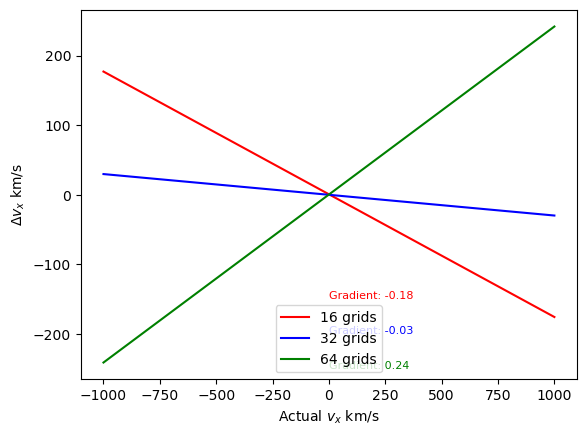

In [45]:
diff_grads_delta()

In [30]:
def deltav_slice(z1,bins,x_range=x_range,y_range=y_range,z_range=z_range):
    grid=500/bins
    overdensity,edges=full_overdensity_histogram(bins)
    rvx,rvy,rvz=compute_linear_velocity_field(overdensity,edges[0])
    rvx,rvy,rvz=2*rvx,2*rvy,2*rvz
    tvx,tvy,tvz,ex1,ex2,ex3=full_velos_stds(bins)
    magt,magr=np.sqrt(tvx**2+tvy**2+tvz**2),np.sqrt(rvx**2+rvy**2+rvz**2)
    z_bin = np.where((edges[2][:-1] >= z1) & (edges[2][:-1] < z1+grid))[0]
    deltax,deltay,deltaz,deltam=abs(rvx-tvx),abs(rvy-tvy),abs(rvz-tvz),abs(magr-magt)
    vxslice,vyslice,vzslice,magslice=deltax[:,:,z_bin[0]],deltay[:,:,z_bin[0]],deltaz[:,:,z_bin[0]],deltam[:,:,z_bin[0]]
    densityslice=overdensity[:,:,z_bin[0]]
    capped=[[600 if x > 600 else x for x in row] for row in magslice]
    fig,axes=plt.subplots(1,2,figsize=(12,4))
    ax1,ax2=axes[0],axes[1]
    im1=ax1.imshow(np.rot90(capped), extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='viridis')
    ax1.set_xlabel('x coords')
    ax1.set_ylabel('y coords')
    fig.colorbar(im1,ax=ax1,label='$|\Delta v_{\\text{mag}}|$')
    im2=ax2.imshow(np.rot90(np.log10(densityslice+1)), extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='viridis')
    ax2.set_xlabel('x coords')
    ax2.set_ylabel('y coords')
    fig.colorbar(im2,ax=ax2,label='$\log_{10}(\delta+1)$')
    path = '../Figures/NewPlots/Delta v mag vs overdensity along z=({:.2f},{:.2f}) (gridsize of {:.2f}).png'.format(z1,z1+grid,grid)
    plt.savefig(path, dpi=300)
    plt.close()
    return

<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:22: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_733/1384553145.py:18: SyntaxWarning: invalid escape sequence '\D'
  fig.colorbar(im1,ax=ax1,label='$|\Delta v_{\\text{mag}}|$')
/tmp/ipykernel_733/1384553145.py:22: SyntaxWarning: invalid escape sequence '\l'
  fig.colorbar(im2,ax=ax2,label='$\log_{10}(\delta+1)$')


In [31]:
def small_deltav_slice(z1,bins,a,b,c,d,e,f,x_range=x_range,y_range=y_range,z_range=z_range):
    grid=500/bins
    smallbins=int(bins/2)
    mask=(x<=125)&(x>=-125)&(y<=125)&(y>=-125)&(z<=125)&(z>=-125)
    newx,newy,newz=x[mask],y[mask],z[mask]
    smalldense,ed=full_overdensity_histogram(smallbins,x=newx,y=newy,z=newz,range=250)
    tvx,tvy,tvz,ex1,ex2,ex3=full_velos_stds(bins)
    tvx,tvy,tvz=tvx[16:48,16:48,16:48],tvy[16:48,16:48,16:48],tvz[16:48,16:48,16:48]
    z_bin = np.where((ed[2][:-1] >= z1) & (ed[2][:-1] < z1+grid))[0]
    magt,magr1,magr2=np.sqrt(tvx**2+tvy**2+tvz**2),np.sqrt(a**2+b**2+c**2),np.sqrt(d**2+e**2+f**2)
    deltax1,deltay1,deltaz1,deltam1=abs(a-tvx),abs(b-tvy),abs(c-tvz),abs(magr1-magt)
    deltax2,deltay2,deltaz2,deltam2=abs(d-tvx),abs(e-tvy),abs(f-tvz),abs(magr2-magt)
    vxslice1,vyslice1,vzslice1,magslice1=deltax1[:,:,z_bin[0]],deltay1[:,:,z_bin[0]],deltaz1[:,:,z_bin[0]],deltam1[:,:,z_bin[0]]
    vxslice2,vyslice2,vzslice2,magslice2=deltax2[:,:,z_bin[0]],deltay2[:,:,z_bin[0]],deltaz2[:,:,z_bin[0]],deltam2[:,:,z_bin[0]]
    densityslice=smalldense[:,:,z_bin[0]]
    capped1=[[600 if x > 600 else x for x in row] for row in vzslice1]
    capped2=[[600 if x > 600 else x for x in row] for row in vzslice2]
    fig,axes=plt.subplots(1,3,figsize=(16,4))
    ax1,ax2,ax3=axes[0],axes[1],axes[2]
    im1=ax1.imshow(np.rot90(capped1), extent=[x_range[0]/2, x_range[1]/2, y_range[0]/2, y_range[1]/2], cmap='viridis')
    ax1.set_xlabel('x coords')
    ax1.set_ylabel('y coords',labelpad=-18)
    ax1.set_title('Cut then recon')
    cbar=fig.colorbar(im1,ax=ax1)
    cbar.set_label('$|\Delta v_z|$')
    im2=ax2.imshow(np.rot90(capped2), extent=[x_range[0]/2, x_range[1]/2, y_range[0]/2, y_range[1]/2], cmap='viridis')
    ax2.set_xlabel('x coords')
    ax2.set_ylabel('y coords',labelpad=-18)
    ax2.set_title('Recon then cut')
    cbar=fig.colorbar(im2,ax=ax2)
    cbar.set_label('$|\Delta v_z|$')
    im3=ax3.imshow(np.rot90(np.log10(densityslice+1)), extent=[x_range[0]/2, x_range[1]/2, y_range[0]/2, y_range[1]/2], cmap='viridis')
    ax3.set_xlabel('x coords')
    ax3.set_ylabel('y coords',labelpad=-18)
    ax3.set_title('Overdensity')
    cbar=fig.colorbar(im3,ax=ax3)
    cbar.set_label('$\log_{10}(\delta+1)$')
    path = '../Figures/NewPlots/Cut Delta vz vs overdensity along z=({:.2f},{:.2f}) (gridsize of {:.2f}).png'.format(z1,z1+grid,grid)
    plt.savefig(path, dpi=300)
    plt.close()
    return

<>:25: SyntaxWarning: invalid escape sequence '\D'
<>:31: SyntaxWarning: invalid escape sequence '\D'
<>:37: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\D'
<>:31: SyntaxWarning: invalid escape sequence '\D'
<>:37: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_733/948050055.py:25: SyntaxWarning: invalid escape sequence '\D'
  cbar.set_label('$|\Delta v_z|$')
/tmp/ipykernel_733/948050055.py:31: SyntaxWarning: invalid escape sequence '\D'
  cbar.set_label('$|\Delta v_z|$')
/tmp/ipykernel_733/948050055.py:37: SyntaxWarning: invalid escape sequence '\l'
  cbar.set_label('$\log_{10}(\delta+1)$')


In [32]:
#returns two reconstructed fields, one from the full smaple and one from a reduced sample
def smaller_recon(bins,x=x,y=y,z=z):
    smallbins=int(bins/2)
    mask=(x<=125)&(x>=-125)&(y<=125)&(y>=-125)&(z<=125)&(z>=-125)
    newx,newy,newz=x[mask],y[mask],z[mask]
    smallo,ed1=full_overdensity_histogram(smallbins,x=newx,y=newy,z=newz,range=250)
    bigo,ed2=full_overdensity_histogram(bins)
    smallrx,smallry,smallrz=compute_linear_velocity_field(smallo,ed1[0])
    bigrx,bigry,bigrz=compute_linear_velocity_field(bigo,ed2[0])
    cutrx,cutry,cutrz=bigrx[16:48,16:48,16:48],bigry[16:48,16:48,16:48],bigrz[16:48,16:48,16:48]
    return 2*smallrx,2*smallry,2*smallrz,2*cutrx,2*cutry,2*cutrz

In [33]:
def histogram_smaller_recon(a,b,c,d,e,f):
    diffx,diffy,diffz=abs(a-d),abs(b-e),abs(c-f)
    plt.hist(diffx.flatten(),bins=25,label='x',alpha=0.5)
    plt.hist(diffy.flatten(),bins=25,label='y',alpha=0.5)
    plt.hist(diffz.flatten(),bins=25,label='z',alpha=0.5)
    plt.xlabel('Difference in velocities (km/s)')
    plt.ylabel('Frequency')
    plt.legend()
    path = '../Figures/NewPlots/Difference in reconstructed velocity of sample.png'
    plt.savefig(path, dpi=300)
    plt.close()
    return

In [34]:
def cut_best_fit(bins,a,b,c,d,e,f):
    tvx,tvy,tvz,ex1,ex2,ex3=full_velos_stds(bins)
    tvx,tvy,tvz=tvx[16:48,16:48,16:48],tvy[16:48,16:48,16:48],tvz[16:48,16:48,16:48]
    flatvx,flatvy,flatvz=tvx.flatten(),tvy.flatten(),tvz.flatten()
    flatrx1,flatry1,flatrz1=a.flatten(),b.flatten(),c.flatten()
    flatrx2,flatry2,flatrz2=d.flatten(),e.flatten(),f.flatten()
    grad,inter=np.polyfit(flatvx,flatrx1,1)
    texty='Cut then recon gradient: {:.2f}'.format(grad)
    xvals=np.linspace(-1000,1000,10000)
    plt.plot(xvals,grad*xvals+inter,color='r',label=texty)
    grad,inter=np.polyfit(flatvx,flatrx2,1)
    texty='Recon then cut gradient: {:.2f}'.format(grad)
    xvals=np.linspace(-1000,1000,10000)
    plt.plot(xvals,grad*xvals+inter,color='b',label=texty)
    plt.ylabel('Reconstructed $v_x$ km/s')
    plt.xlabel('Actual $v_x$ km/s')
    plt.legend()
    path = '../Figures/NewPlots/Cut reconstructed vs actual velocity gradients'
    plt.savefig(path, dpi=300)
    plt.close()
    return

In [35]:
# calculate the mean and std in each box for each component
def full_recon_mean_std(bins,rvx,rvy,rvz,x=x,y=y,z=z,vx=vx,vy=vy,vz=vz):
    # lin recon gives velocity in every cell (basically a mean)
    # want to find difference between this val and every val put into that box
    # from that, find the mean and find the std
    # creates 6 bins x bins x bins matrices with the grouped velocities and stds 
    # returns the 6 matrices
    hist,edges=full_density_histogram(bins)
    x_indices=np.digitize(x,edges[0])-1
    y_indices=np.digitize(y,edges[1])-1
    z_indices=np.digitize(z,edges[2])-1
    xidx = np.clip(x_indices, 0, bins-1)
    yidx = np.clip(y_indices, 0, bins-1)
    zidx = np.clip(z_indices, 0, bins-1)
    directx=np.zeros((bins,bins,bins))
    directy=np.zeros((bins,bins,bins))
    directz=np.zeros((bins,bins,bins))
    stdxsq=np.zeros((bins,bins,bins))
    stdysq=np.zeros((bins,bins,bins))
    stdzsq=np.zeros((bins,bins,bins))
    stdx=np.zeros((bins,bins,bins))
    stdy=np.zeros((bins,bins,bins))
    stdz=np.zeros((bins,bins,bins))
    counts=np.zeros((bins,bins,bins))
    np.add.at(directx, (xidx, yidx, zidx), abs(vx-rvx[xidx,yidx,zidx]))
    np.add.at(directy, (xidx, yidx, zidx), abs(vy-rvy[xidx,yidx,zidx]))
    np.add.at(directz, (xidx, yidx, zidx), abs(vz-rvz[xidx,yidx,zidx]))
    np.add.at(counts, (xidx, yidx, zidx), 1)
    directx[counts > 0] /= counts[counts > 0]
    directy[counts > 0] /= counts[counts > 0]
    directz[counts > 0] /= counts[counts > 0]
    np.add.at(stdxsq, (xidx, yidx, zidx), (abs(vx-rvx[xidx,yidx,zidx])-directx[xidx,yidx,zidx])**2)
    np.add.at(stdysq, (xidx, yidx, zidx), (abs(vy-rvy[xidx,yidx,zidx])-directy[xidx,yidx,zidx])**2)
    np.add.at(stdzsq, (xidx, yidx, zidx), (abs(vz-rvz[xidx,yidx,zidx])-directz[xidx,yidx,zidx])**2)
    stdx[counts > 0] = np.sqrt(stdxsq[counts > 0] / counts[counts>0])
    stdy[counts > 0] = np.sqrt(stdysq[counts > 0] / counts[counts>0])
    stdz[counts > 0] = np.sqrt(stdzsq[counts > 0] / counts[counts>0])
    return directx, directy, directz, stdx, stdy, stdz

In [36]:
def histogram_diffs(diffx,diffy,diffz,stdiffx,stdiffy,stdiffz):
    plt.hist(np.log10(diffx.flatten()+1),bins=25,color='r',alpha=0.5,label='$v_x$')
    plt.hist(np.log10(diffy.flatten()+1),bins=25,color='b',alpha=0.5,label='$v_y$')
    plt.hist(np.log10(diffz.flatten()+1),bins=25,color='g',alpha=0.5,label='$v_z$')
    plt.xlabel('$\log_{10}(|\Delta v|)$')
    plt.ylabel('Frequency')
    plt.legend()
    path = '../Figures/NewPlots/Histogram of mean differences between actual and reconstructed velocities'
    plt.savefig(path, dpi=300)
    plt.close()
    plt.hist(np.log10(stdiffx.flatten()+1),bins=25,color='r',alpha=0.5,label='$v_x$')
    plt.hist(np.log10(stdiffy.flatten()+1),bins=25,color='b',alpha=0.5,label='$v_y$')
    plt.hist(np.log10(stdiffz.flatten()+1),bins=25,color='g',alpha=0.5,label='$v_z$')
    plt.xlabel('$\log_{10}(\sigma_{|\Delta v|})$')
    plt.ylabel('Frequency')
    plt.legend()
    path = '../Figures/NewPlots/Histogram of STDs in differences between actual and reconstructed velocities'
    plt.savefig(path, dpi=300)
    plt.close()
    return

<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:14: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:14: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_733/557046062.py:5: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\log_{10}(|\Delta v|)$')
/tmp/ipykernel_733/557046062.py:14: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\log_{10}(\sigma_{|\Delta v|})$')


In [37]:
def new_deltav_slice(z1,bins,x_range=x_range,y_range=y_range,z_range=z_range):
    grid=500/bins
    overdensity,edges=full_overdensity_histogram(bins)
    rvx,rvy,rvz=compute_linear_velocity_field(overdensity,edges[0])
    rvx,rvy,rvz=2*rvx,2*rvy,2*rvz
    deltax,deltay,deltaz,stdx,stdy,stdz=full_recon_mean_std(bins,rvx,rvy,rvz)
    z_bin = np.where((edges[2][:-1] >= z1) & (edges[2][:-1] < z1+grid))[0]
    vxslice,vyslice,vzslice=deltax[:,:,z_bin[0]],deltay[:,:,z_bin[0]],deltaz[:,:,z_bin[0]]
    sxslice,syslice,szslice=stdx[:,:,z_bin[0]],stdy[:,:,z_bin[0]],stdz[:,:,z_bin[0]]#,deltam[:,:,z_bin[0]]
    densityslice=overdensity[:,:,z_bin[0]]
    capped=[[600 if x > 600 else x for x in row] for row in vzslice]
    capped1=[[600 if x > 600 else x for x in row] for row in szslice]
    fig,axes=plt.subplots(1,3,figsize=(16,4))
    ax1,ax2,ax3=axes[0],axes[1],axes[2]
    im1=ax1.imshow(np.rot90(capped), extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='viridis')
    ax1.set_xlabel('x coords')
    ax1.set_ylabel('y coords',labelpad=-18)
    ax1.set_title('Mean')
    fig.colorbar(im1,ax=ax1,label='$|\Delta v_{z}|$')
    im2=ax2.imshow(np.rot90(capped1), extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='viridis')
    ax2.set_xlabel('x coords')
    ax2.set_ylabel('y coords',labelpad=-18)
    ax2.set_title('STD')
    fig.colorbar(im2,ax=ax2,label='$\sigma_{|\Delta vz|}$')
    im3=ax3.imshow(np.rot90(np.log10(densityslice+1)), extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='viridis')
    ax3.set_xlabel('x coords')
    ax3.set_ylabel('y coords',labelpad=-18)
    ax3.set_title('Overdensity')
    fig.colorbar(im3,ax=ax3,label='$\log_{10}(\delta+1)$')
    path = '../Figures/NewPlots/New delta vz vs overdensity along z=({:.2f},{:.2f}) (gridsize of {:.2f}).png'.format(z1,z1+grid,grid)
    plt.savefig(path, dpi=300)
    plt.close()
    return

<>:19: SyntaxWarning: invalid escape sequence '\D'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\l'
<>:19: SyntaxWarning: invalid escape sequence '\D'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_733/1655313066.py:19: SyntaxWarning: invalid escape sequence '\D'
  fig.colorbar(im1,ax=ax1,label='$|\Delta v_{z}|$')
/tmp/ipykernel_733/1655313066.py:24: SyntaxWarning: invalid escape sequence '\s'
  fig.colorbar(im2,ax=ax2,label='$\sigma_{|\Delta vz|}$')
/tmp/ipykernel_733/1655313066.py:29: SyntaxWarning: invalid escape sequence '\l'
  fig.colorbar(im3,ax=ax3,label='$\log_{10}(\delta+1)$')


In [42]:
def diff_grads_delta_binned():
    grids=[16,32,64]
    cols=['r','b','g']
    k=0
    for i,col in zip(grids,cols):
        overdensity,edges=full_overdensity_histogram(i)
        rvx,rvy,rvz=compute_linear_velocity_field(overdensity,edges[0])
        tvx,tvy,tvz,ex1,ex2,ex3=full_velos_stds(i)
        dvx,dvy,dvz=tvx-rvx,tvy-rvy,tvz-rvz
        flattx,flatdx=tvx.flatten(),dvx.flatten()
        binning=np.linspace(-1000,1000,26)
        digit=np.digitize(flattx,binning)-1
        digit=np.clip(digit, 0, 25)
        listy=np.zeros(26)
        stdsq=np.zeros(26)
        counter=np.zeros(26)
        sem=np.zeros(26)
        np.add.at(listy,digit,flatdx)
        np.add.at(counter,digit,1)
        listy[counter > 0] /= counter[counter > 0]
        np.add.at(stdsq,digit,(listy[digit]-flatdx)**2)
        sem[counter > 0] = np.sqrt(stdsq[counter > 0]) / counter[counter>0] #divide by sqrtn again #also swap
        grad,inter=np.polyfit(binning,listy,1)
        text=str(i)+' grids'
        xvals=np.linspace(-1000,1000,10000)
        texty='Gradient: {:.2f}'.format(grad)
        plt.errorbar(binning,listy,sem,fmt='.',color=col,label=text)
        plt.plot(xvals,grad*xvals+inter,color=col)
        plt.text(-800,-600-(k*100),texty,color=col,fontsize=8)
        k+=1
    #plt.ylim(-1000,1000)
    plt.ylabel('$\Delta v_x$ km/s')
    plt.xlabel('Actual $v_x$ km/s')
    plt.legend()
    #path = '../Figures/NewPlots/Binned delta reconstructed vs actual velocity gradients with different grids'
    #plt.savefig(path, dpi=300)
    plt.show()
    return

<>:32: SyntaxWarning: invalid escape sequence '\D'
<>:32: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_733/2187052506.py:32: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta v_x$ km/s')


Computing the linear velocity field...
Computing the linear velocity field...
Computing the linear velocity field...


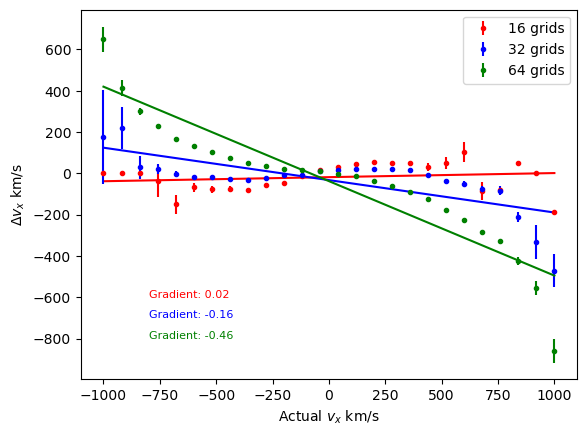

In [43]:
diff_grads_delta_binned() #root n times that!!

Below is the use of each of the above functions...

In [40]:
# every one of the above functions includes the number of grids in 1 dimension, and sometimes a starting z value
gridnum=64 # best for a 2^n number
zstart=0 # some number between -250 and 250 but be careful of grid size obvs

In [106]:
a,b,c,d,e,f=smaller_recon(gridnum)

Computing the linear velocity field...
Computing the linear velocity field...


In [42]:
histogram_smaller_recon(a,b,c,d,e,f)

In [43]:
deltav_slice(zstart,gridnum)

Computing the linear velocity field...


In [145]:
new_deltav_slice(zstart,gridnum)

Computing the linear velocity field...


In [79]:
small_deltav_slice(zstart,gridnum,a,b,c,d,e,f)

In [94]:
cut_best_fit(gridnum,a,b,c,d,e,f)

In [118]:
plot_density(zstart,gridnum)

In [119]:
plot_density_velocities(zstart,gridnum)

In [133]:
plot_overdensity(zstart,gridnum)

In [121]:
plot_overdensity_velocities(zstart,gridnum)

In [103]:
overdensity,edges=full_overdensity_histogram(gridnum)

In [32]:
print(edges[0])

[-250.     -242.1875 -234.375  -226.5625 -218.75   -210.9375 -203.125
 -195.3125 -187.5    -179.6875 -171.875  -164.0625 -156.25   -148.4375
 -140.625  -132.8125 -125.     -117.1875 -109.375  -101.5625  -93.75
  -85.9375  -78.125   -70.3125  -62.5     -54.6875  -46.875   -39.0625
  -31.25    -23.4375  -15.625    -7.8125    0.        7.8125   15.625
   23.4375   31.25     39.0625   46.875    54.6875   62.5      70.3125
   78.125    85.9375   93.75    101.5625  109.375   117.1875  125.
  132.8125  140.625   148.4375  156.25    164.0625  171.875   179.6875
  187.5     195.3125  203.125   210.9375  218.75    226.5625  234.375
  242.1875  250.    ]


In [104]:
a,b,c=compute_linear_velocity_field(overdensity,edges[0])

Computing the linear velocity field...


In [105]:
vxcon,vycon,vzcon=2*a,2*b,2*c

In [114]:
diffx,diffy,diffz,stdiffx,stdiffy,stdiffz=full_recon_mean_std(64,vxcon,vycon,vzcon)

In [133]:
histogram_diffs(diffx,diffy,diffz,stdiffx,stdiffy,stdiffz)

In [62]:
plot_slice_reconstruct(vxcon,vycon,zstart,gridnum)

In [63]:
plot_overlayed_velocities(vxcon,vycon,zstart,gridnum)

In [25]:
histogram_means(gridnum)

In [129]:
histogram_stds(gridnum)

In [131]:
histogram_overdensities(gridnum)

In [35]:
q,w,e,r,t,y=full_velos_stds(gridnum)

In [43]:
histogram_deltav()

Computing the linear velocity field...
Computing the linear velocity field...
Computing the linear velocity field...
Computing the linear velocity field...


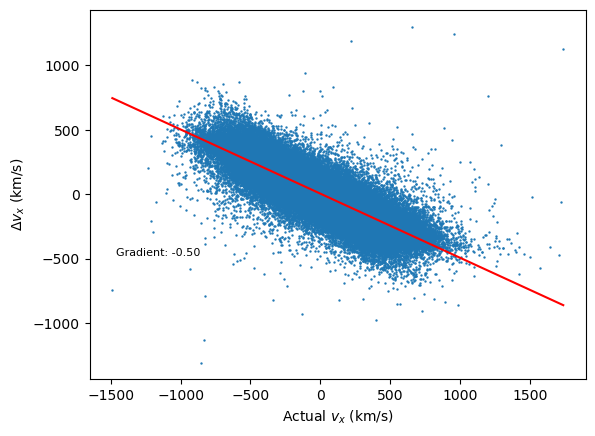

In [67]:
uvonv(q,w,e,vxcon,vycon,vzcon,gridnum)

In [44]:
diff_grads()

Computing the linear velocity field...
Computing the linear velocity field...
Computing the linear velocity field...
Computing the linear velocity field...


In [50]:
diff_grads_delta()

Computing the linear velocity field...
Computing the linear velocity field...
Computing the linear velocity field...
Computing the linear velocity field...


In [65]:
plot_truevrecon(q,w,e,vxcon,vycon,vzcon,gridnum)

In [51]:
std1,std2=histogram_comparison_mag_stds(q,w,e,vxcon,vycon,vzcon,gridnum)
print(std1,std2)

191.68870338314917 255.9871556839047


In [39]:
histogram_comparison(q,w,e,vxcon,vycon,vzcon,gridnum)